In [1]:
import numpy as np
import pandas as pd

from functools import partial
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [184]:
def retrieve_csv_file(path):
    """This function reads the csv file using pandas and returns a DataFrame"""
    names= ['labels', 'cap-shape', 'cap-color', 'cap-surface', 'bruises', 'odor', 
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
            'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
            'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
            'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 
            'population', 'habitat'
           ]
    return pd.read_csv(path, names=names)

In [185]:
def split_dataset(dataframe: pd.DataFrame, test_size=0.25, shuffle: bool =True):
    """
    Shuffle the dataset and returns the split the data using the fractional test_size.
    Note, these operations are performed one the whole datasets
    """
    
    from sklearn.model_selection import train_test_split
    
    # shuffle the dataset randomly
    if shuffle:
        shuffled_index = np.random.permutation(len(dataframe))
        data = dataframe.iloc[shuffled_index]
        
        # split the dataset
        return train_test_split(dataframe, shuffle=shuffle, test_size=test_size)
    
    return train_test_split(dataframe, shuffle=shuffle, test_size=test_size)
    
    

In [186]:
def split_label_from_dataset(dataframe: pd.DataFrame, label, inplace: bool =False):
    """
    Retrieve the label from the dataset using it column's index
    if inplace is True, it also permanently remove the label from the 
    DataFrame it was retrieved from.
    """
    labels = dataframe[label]
    
    if inplace:
        dataframe.drop(label, inplace=inplace)
    
    return labels

In [228]:
data = retrieve_csv_file('data/expanded.csv')

In [229]:
train, test = split_dataset(data)
train.shape, test.shape

((6312, 23), (2104, 23))

In [230]:
train, valid = split_dataset(train)
train.shape, valid.shape

((4734, 23), (1578, 23))

From my previous analysis of the data, there were a few features which contains a lot of similiarities with each other.
So I am going to use the extreme measure of completely removing the similar features, and see if I am going to still get a good model prediction without them

In [203]:
similar_features = [
    'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring'
]

# Drop the similar features from the train, test, valid dataset
train.drop(similar_features, axis=1, inplace=True)
valid.drop(similar_features, axis=1, inplace=True)
test.drop(similar_features, axis=1, inplace=True)

c:\users\dell\python3.8\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [207]:
y_train = split_label_from_dataset(train, label='labels')
X_train = train.iloc[:, 1:]

y_valid = split_label_from_dataset(valid, label='labels')
X_valid = valid.iloc[:, 1:]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((4734, 18), (4734,), (1578, 18), (1578,))

All the features are categorical in representation, and no machine learning algorithm can learn a categorical feature. So I have to first convert it to some sort of numerical values before feeding it to the algorithm. Now herein lies the situation, I can percieve no sort of ordinality to the values, so it makes no sense to encode them using the OrdinalEncoder in sklearn. though you could do and see what value you will get

Therefore I am going to use the OneHotEncoders to encode the categorical features and see how it does


In [87]:
def convert_to_numpy(dataframe: pd.DataFrame):
    """
    convert the DataFrame to a numpy array
    """
    data = dataframe.to_numpy()
    
    return data

In [208]:
X_train, X_valid = convert_to_numpy(X_train), convert_to_numpy(X_valid)
X_train.shape, X_valid.shape

((4734, 18), (1578, 18))

In [89]:
def encode_features(data: np.ndarray, encode_type='OneHotEncoder'):
    """
    Encode the data features using the specified encoders 
    if encode_type = OrdinalEncoder, the OrdinalEncoder is used
    if the OneHotEncoder is used to encode the feauters which is the default
    if encoder is an object, the encoder must support the fit and transform method
    
    it displays an error message if none of the encoder is not supported
    and returns the transformed features and the encoder used to encode the features,
    so that it can be use to encode the test dataset
    """
    try:
        if type(encode_type) == str:
            if 'onehot' in encode_type.lower():
                from sklearn.preprocessing import OneHotEncoder

                encoder = OneHotEncoder(sparse=False)
                encoder.fit(data)

                return encoder, encoder.transform(data)
            elif 'ordinal' in encode_type.lower():
                from sklearn.preprocessing import OrdinalEncoder

                encoder = OrdinalEncoder()
                encoder.fit(data)

                return encoder, encoder.transform(data)
            else:
                raise TypeError
        elif type(encode_type) == type:  # check to see if the encoder is an object not a string
            try:
                encode_type.fit(data)
            except TypeError:
                # if the encoder object has not been instantiated by the user before passing it as an argument
                # the program will automatically instantiate it and perform fit on it
                if 'onehot' in str(encode_type).lower():
                    encoder = encode_type(sparse=False)
                else:
                    encoder = encode_type()
                    
                encoder.fit(data)

            return encoder, encoder.transform(data)
        else:
            raise TypeError("Invalid encode type")
    except TypeError:
        print("Invalid encode type")


In [209]:
encoder, X_train_encoded = encode_features(X_train, encode_type='onehot')
X_valid_encoded = encoder.transform(X_valid)

X_train_encoded.shape, X_valid_encoded.shape

((4734, 91), (1578, 91))

In [210]:
# Building my model with their default hyperparameters

GradientBooster = partial(GradientBoostingClassifier, 
                          n_estimators=1000, 
                          learning_rate=0.01
                         )
RandomForest = partial(RandomForestClassifier,
                       n_estimators=300,
                       n_jobs=-1
                      )

In [211]:
booster = GradientBooster()
forest = RandomForest()

In [212]:
booster.fit(X_train_encoded, y_train)
booster.score(X_train_encoded, y_train), booster.score(X_valid_encoded, y_valid)

(1.0, 1.0)

In [213]:
forest.fit(X_train_encoded, y_train)
forest.score(X_train_encoded, y_train), forest.score(X_valid_encoded, y_valid)

(1.0, 1.0)

In [215]:
y_test = split_label_from_dataset(test, label='labels')
X_test = test.iloc[:, 1:]

In [216]:
X_test = convert_to_numpy(X_test)

In [217]:
X_test_encoded = encoder.transform(X_test)
X_test_encoded.shape

(2104, 91)

In [218]:
booster.score(X_test_encoded, y_test), forest.score(X_test_encoded, y_test)

(1.0, 1.0)

Even with the extreme measure of completely removing all the duplicates, the model was still capable of generalizing extremely well. 
Next I will try to see if we can get to get comparable performance, but with a more fewer features. To do that I will visualize what, 
the model learned, and what features it considers as more importance

In [135]:
def plot_importanc(clf):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(30, 10))
    sns.barplot(x=list(range(len(clf.feature_importances_))), y=clf.feature_importances_)

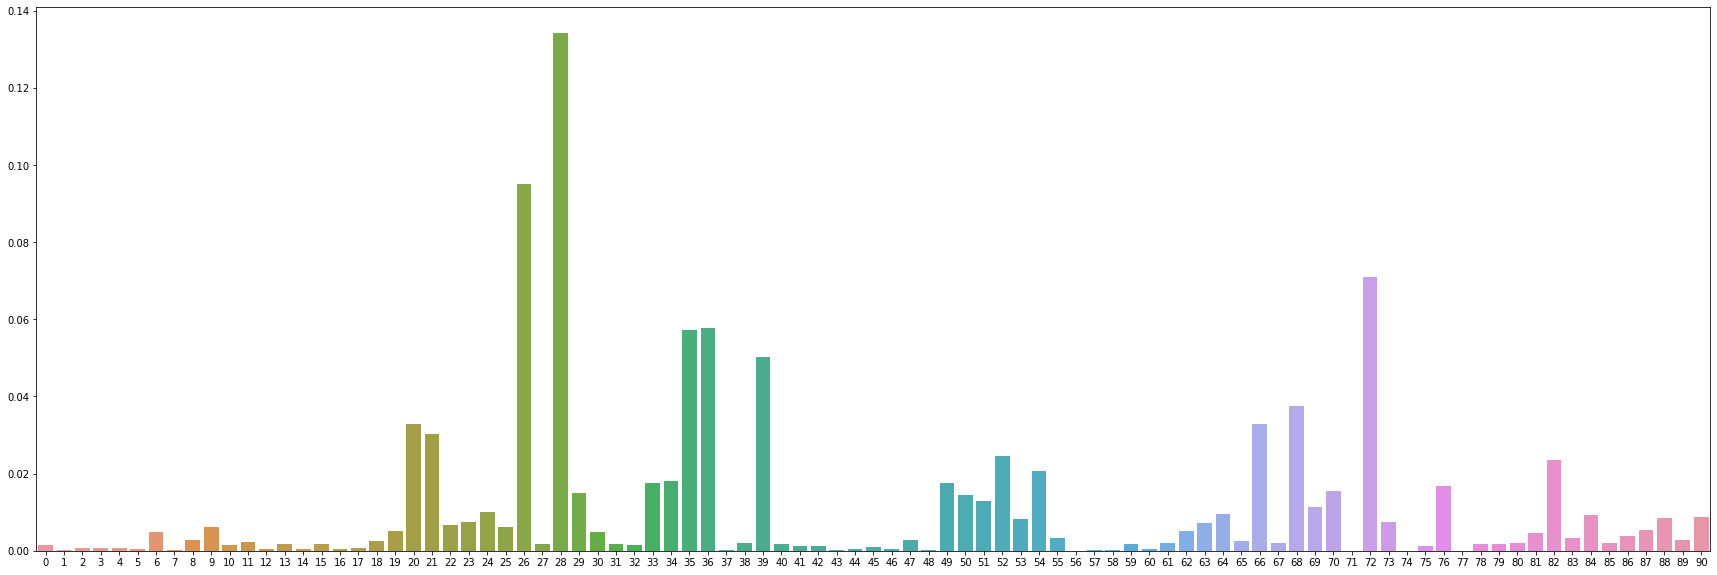

In [136]:
plot_importanc(forest)

These are the features both model considers importance, and from the look of things the GradientBoostingClassifier seems to suggest that only a whole lot fewer feature (3 or 4) are actually needed to build the model and that I can just throw the rest away. While RandomForestClassifier thinks quite a bit more features are needed (judging by the peaks, 5 or 6).

I am going to go with the suggestion of GradientBoostingClassifier and see will lead to a good generalization performance, and also whether the RandomForestClassifier which has a different suggestion will still perform well on the data

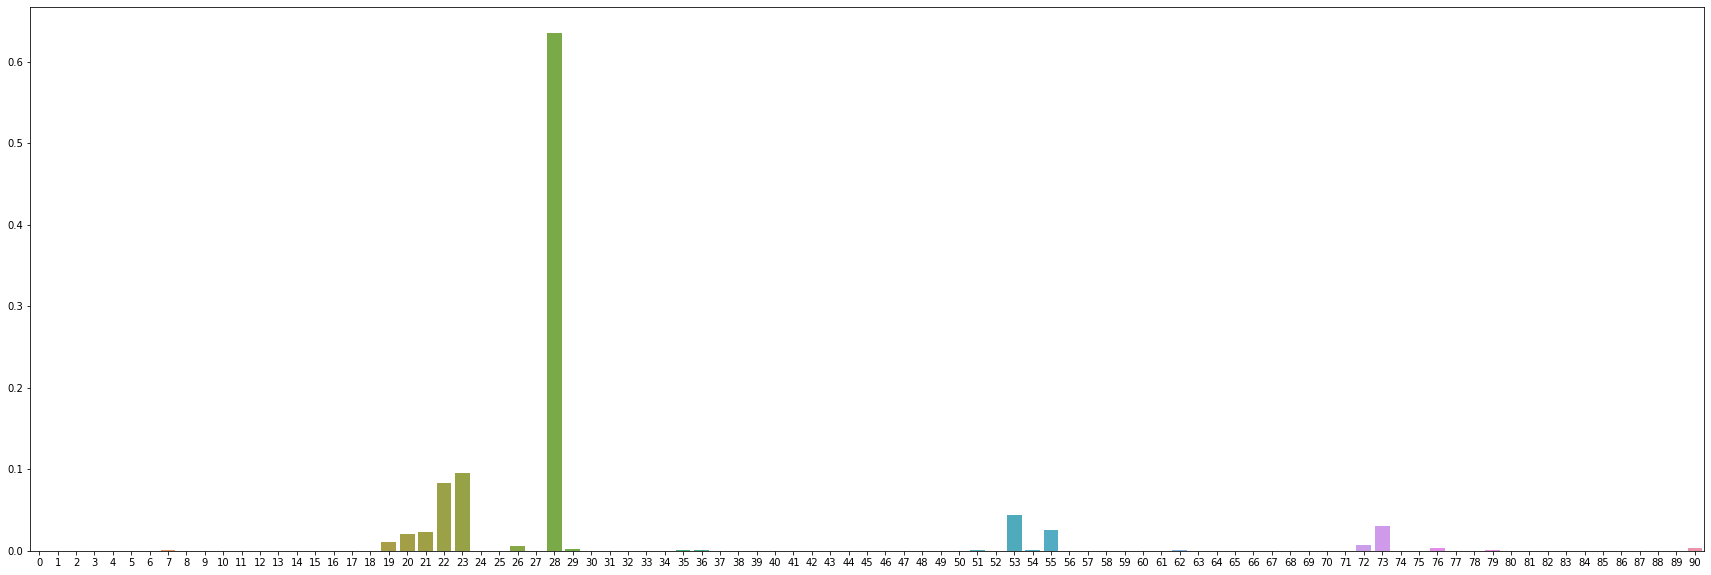

In [138]:
plot_importanc(booster)

In [242]:
data = retrieve_csv_file('data/expanded.csv')

In [243]:
train, test = split_dataset(data)
train.shape, test.shape

((6312, 23), (2104, 23))

In [244]:
train, valid = split_dataset(train)
train.shape, valid.shape

((4734, 23), (1578, 23))

In [245]:
# features_to_drop = [1, 2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
# train.drop(columns=features_to_drop, inplace=True)
# valid.drop(columns=features_to_drop, inplace=True)
# test.drop(columns=features_to_drop, inplace=True)

features_to_use = ['labels', 'bruises', 'odor', 'stalk-root', 'stalk-surface-above-ring']
train = train[features_to_use]
valid = valid[features_to_use]
test = test[features_to_use]

In [246]:
y_train = split_label_from_dataset(train, label='labels')
X_train = train.iloc[:, 1:]

y_valid = split_label_from_dataset(valid, label='labels')
X_valid = valid.iloc[:, 1:]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((4734, 4), (4734,), (1578, 4), (1578,))

In [247]:
X_train, X_valid = convert_to_numpy(X_train), convert_to_numpy(X_valid)
X_train.shape, X_valid.shape

((4734, 4), (1578, 4))

In [248]:
encoder, X_train_encoded = encode_features(X_train, encode_type='onehot')
X_valid_encoded = encoder.transform(X_valid)

X_train_encoded.shape, X_valid_encoded.shape

((4734, 20), (1578, 20))

In [249]:
booster = GradientBooster()
forest = RandomForest()

In [250]:
booster.fit(X_train_encoded, y_train)
booster.score(X_train_encoded, y_train), booster.score(X_valid_encoded, y_valid)

(0.9869032530629489, 0.9885931558935361)

In [251]:
forest.fit(X_train_encoded, y_train)
forest.score(X_train_encoded, y_train), forest.score(X_valid_encoded, y_valid)

(0.9869032530629489, 0.9885931558935361)

In [252]:
y_test = split_label_from_dataset(test, label='labels')
X_test = test.iloc[:, 1:]

In [253]:
X_test = convert_to_numpy(X_test)

In [254]:
X_test_encoded = encoder.transform(X_test)
X_test_encoded.shape

(2104, 20)

In [255]:
booster.score(X_test_encoded, y_test), forest.score(X_test_encoded, y_test)

(0.9847908745247148, 0.9847908745247148)

Even using four(4) features I was able to get a comparable model to model using the full dataset